# Dividend-Only Heterogeneous-Agent Asset Pricing 

Let's define the simplest possible asset-pricing agent. We will strip away as much as possible until we have the most basic agent, and then use that agent to incrementally explore a number of possible feedback mechanisms which may be quite important in "highly heterogeneous"-agent general equilibrium. These will include:

* differences in wealth levels
* differences in income processes (due to differing ideosyncratic shocks)
* differences in beliefs
* differences in learning mechanisms and/or experience 
* differences in preferences, including risk aversion and time discounting
* differences in portfolio allocations or policy functions due to heuristics

These are roughly in order of "palatability" -- while few people will disagree that differences in wealth levels are important, it becomes harder to measure (and justify) differences further down the list, such as differences in preferences or heuristics. 

The most basic asset pricing model will allow us to think about the effects of heterogeneity in the above characteristics easily, before moving to more complicated situations. 

In addition, solving the simplest model first will provide us a foundation against which to test more complex models to look for bugs and coding errors. This second usage will become more apparent as we progress. 

For simplicity of exposition we will use a two-period model to begin. Under a number of circumstances, the infinite-period model collapses to the two period model for optimization purposes. We will explore this in detail much later. 

## The Agent Problem

We will employ the two-period basic asset pricing problem from the first chapter of Cochrane (2001):

$$
\begin{aligned}
\underset{\xi_2}{\mathrm{max}} & \;\; u(c_{1})  + \beta \mathbb{E}\left[u(c_{2})\right] \\
c_1 & = \xi_1 d_1 + (\xi_1 - \xi_2)p_1 \\ 
c_{2} & = \xi_2 d_2 \\
c_{t} & \ge 0 \forall t \\
\xi_{t+1} & \ge -\xi_{t} \forall t
\end{aligned}
$$


The agent in question begins period 1 with an endowment of the single risky asset available in the economy, $\xi_1$, which has already realized divided $d_1$ before the period began. Thus the income indowment for the agent at the beginning of period 1 is $\xi_1 d_1$.


To solve the problem substitute the constraints into the objective, take first derivative and set to zero to find the Euler. We arive at the familiar expression:

$$
\begin{aligned}
u'(c_1)p_1 = \beta \mathbb{E}\left[u'(c_{2}) d_2 \right]
\end{aligned}
$$

For CRRA utility this is straightforward to solve algebraically for $\xi_2$:


Log CRRA:

$$
\begin{aligned}
\tilde{\xi_2} = \xi_1 \frac{d_1+p_1}{p_1} \frac{\beta}{1 + \beta}
\end{aligned}
$$


Non-Log CRRA:

$$
\begin{aligned}
\tilde{\xi_2}  = \frac{\xi_1 (d_1 + p_1)}{\left( \frac{\beta}{p_1} \mathbb{E}\left[ d_2^{1-\rho} \right] \right)^{-1/\rho} + p_1}
\end{aligned}
$$

Note that the solutions simply tie the choice $\xi_2$ to already known values and the expected values of $d_2$ at time 2.

The tilde "~" above the the demand indicates that this is unrestricted demand -- we impose the two constraints as follows:

$$
\begin{aligned}
\xi_2 = \min(\xi_1 + \frac{\xi_1 d_1}{p_1}, \max(\tilde{\xi_2}, 0.0))
\end{aligned}
$$


We can examine these two demand functions easily:



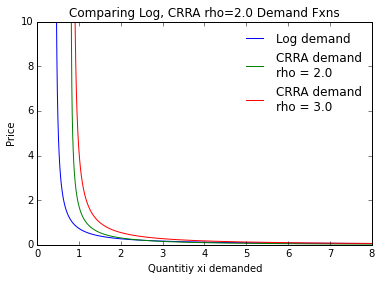

In [5]:
%matplotlib inline
from __future__ import division
import pylab as plt
import numpy as np


# Parameters:
beta = 0.99
rho = 2.0
rho3 = 3.0
xi1 = 0.85
d1 = 1.0
y0=1.0
xi0=1.0

D_vals = np.array([0.01, 0.7, 1.2, 1.7, 1.99])
D_probs = np.array([0.5, 3.0, 5.0, 3.0, 0.5])

# Normalize D_probs...
D_probs = D_probs/float(np.sum(D_probs))


# Define two demand functions:
def log_demand_Tm1(xi1, d1, p1, beta):
    xi2 = ((xi1 * d1) / p1 + xi1) * beta/(1.0 + beta)
    return max( min(xi1 + xi1*d1/p1, xi2), 0.0)

def crra_demand_Tm1(xi1, d1, p1, beta, rho, D_vals, D_probs):
    xi2  = xi1 * (d1 + p1) / ( ((beta / p1) * np.dot(D_vals**(1.0-rho), D_probs) )**(-1.0/rho) + p1)
    return max( min(xi1 + xi1*d1/p1, xi2), 0.0)





# Define some prices:
prices = np.linspace(0.01,10,1000)


log_demands = []
crra_demands = []
crra_demands_rho3 = []

# Make list of rho-values to use here (will also use again below):
rho_list = [1.0, rho, rho3]

for p1 in prices:
    log_demands.append( log_demand_Tm1(xi1, d1, p1, beta) )
    crra_demands.append( crra_demand_Tm1(xi1, d1, p1, beta, rho_list[1], D_vals, D_probs))
    crra_demands_rho3.append( crra_demand_Tm1(xi1, d1, p1, beta, rho_list[2], D_vals, D_probs))

# Plot against prices:
plt.plot(log_demands, prices, label="Log demand")
plt.plot(crra_demands, prices, label="CRRA demand\nrho = "+str(rho))
plt.plot(crra_demands_rho3, prices, label="CRRA demand\nrho = "+str(rho3))
plt.xlabel("Quantitiy xi demanded")
plt.ylabel("Price")
plt.xlim([0.0, 8.0])
plt.legend(loc='best', frameon=False)
plt.title("Comparing Log, CRRA rho="+str(rho)+" Demand Fxns")
plt.show()


If we define multiple agents who have these demand functions, then finding aggregate demand is simple: for ay price, sum across all agents demand at that price. 

Note that this approach allows us to inject potentially complicated balance sheet dynamics into individual demand, and thus aggregate demand as well. For example, if an agent was borrowing on collateral and the value of collateral dropped, the agent may need to suddenly switch from buying to selling an asset. This might create "kinks" in the aggregate demand curve. We will explore this with a few examples below. 


Finding price with these agents is now straightforward -- define a supply for every price (could be fixed total supply) and then numerically find the price which clears the market. That is, find the price which sets aggregate demand to zero. 

We can check that price-finding works by confirming, for example, that the selected price leaves each individual agent with equal marginal utility.

As a first step in this direction, let's codify the demand functions above in an Asset Pricing Agent object. 

In [6]:
class AssetPricingAgent(object):
    '''
    A simple asset-pricing agent based on a two-period CRRA model.
    '''

    def __init__(self, beta, rho, D, D_probs, y0, xi0=0.0):
        '''
        Initialize an asset-pricing agent.

        Parameters
        ----------
        beta : float
            Time discounting factor
        rho : float
            Risk aversion paramter
        D : array_like(float, ndim=2 or 1)
            Payoff values for different states of the dividend
        D_probs : array_like(float, ndim=2 or 1)
            Probabilities associated with payoffs for states in payoff_dividend vector
        y0 : float
            Initial cash endowment
        xi0 : float
            Initial endowment of number of shares of the risky asset

        Returns
        -------
        Nothing
        '''

        # Set agent paramters:
        self.beta, self.rho = beta, rho
        self.xi0 = xi0
        self.y = y0
        self.y0 = self.y    # This indicates "beginning of period" income;
                            # useful for record-keeping during bilateral trade.

        # Ensure that dividend payoffs are sorted from smallest to largest:
        self.D = np.array(D)
        self.D_probs = np.array(D_probs)
        # Sort:
        ii = np.argsort(self.D)
        self.D = self.D[ii]
        self.D_probs = self.D_probs[ii]

        # Quick check:
        assert np.isclose(np.sum(D_probs), 1.0), "Problem: p_dividend does not sum to 1.0: np.sum(D_probs) = " + str(np.sum(D_probs))

        # Initialize utility and demand functions
        self.u  = None
        self.uprime = None
        self.uprimeprime = None
        self.uprime_inverse = None
        self.demand = None

        # Now actually fill in utility and demand functions
        self.update_utility_demand()

        self.p_prev = None


    def renormalize_beliefs(self):
        # Assuming the beliefs have been changed in some way, renormalize them.
        self.D_probs = self.D_probs/sum(self.D_probs)

        # Quick check:
        assert np.isclose(np.sum(D_probs), 1.0), "Problem: p_dividend does not sum to 1.0: np.sum(D_probs) = " + str(np.sum(D_probs))

        # Also automatically reset demand functions appropiriately:
        self.update_utility_demand()


    def update_utility_demand(self):
        # Simply update the utility and demand functions given own current params
        # Initialize utility and demand functions
        self.u, self.uprime, self.uprimeprime, self.uprime_inverse = self.set_utility(self.rho)
        self.demand = self.set_demand(rho=self.rho, y=self.y, xi0=self.xi0,
                                      beta=self.beta, D=self.D,
                                      D_prob=self.D_probs)  #, xi0)

    def set_utility(self, rho):
        '''
        Return the utility functions associated with the risk-aversion parameter
        rho.
        '''
        # Set CRRA utility:
        if rho == 1.0:
            u = np.log
            uprime = lambda c: 1.0/c
            uprimeprime = lambda c: -c**(-2)
            uprime_inverse = lambda z: 1.0/z
        elif rho == 0.0:
            # Then constant utility - risk neutral
            u = lambda c: c
            uprime = lambda c: 1.0
            uprimeprime = lambda c: 0.0
            uprime_inverse = None # Not defined for constant function
        else:
            # The "regular" CRRA
            u = lambda c, oneminusrho=(1.0-rho): c**oneminusrho / oneminusrho
            uprime = lambda c, rho=rho: c**-rho
            uprimeprime = lambda c, rho=rho: -rho*c**(-1.0-rho)
            uprime_inverse = lambda z, rhoinv=(1.0/rho): z**-rhoinv

        return u, uprime, uprimeprime, uprime_inverse


    def set_demand(self, rho, y, xi0, beta, D, D_prob):
        '''
        Set the demand function: xi = f(p)
        '''
        # Set CRRA demand:
        if rho == 1.0:
            # Log demand:
            demand = lambda p,y=y,beta=beta:  max(min( (y+xi0*p) / p * beta/(1+beta), (y+xi0*p) / p), -xi0)
        elif rho == 0.0:
            raise Exception, "Risk Neutral demand not implemented."
            # The problem witn risk-neutral demand: agents will trade to their
            # limits on either side of the risk-neutral price.
            # Confirm
            def demand(p,beta=beta,D=D,D_prob=D_prob):
                risk_free_price = beta * np.dot(D, D_prob)
                if p > risk_free_price:
                    return -xi0
                elif p < risk_free_price:
                    return (y+xi0*p) / p
                else:
                    return xi0
        else:
            # "Regular" CRRA demand:
            def demand(p, y=y, xi0=xi0, beta=beta, D=D, D_prob=D_prob, rho=rho): #, xi0=xi0):
                '''Note: the max imposes the short-selling constraint -- namely,
                the agent cannnot sell more than they have.'''
                xi = (y + xi0*p) * (1.0 / ( (beta/p *  np.dot(D**(1.0 - rho), D_prob) )**(-1.0/rho) + p) )
                return max(min( xi, (y+xi0*p) / p), -xi0)

        return demand


We can recreate the demand functions shown above:

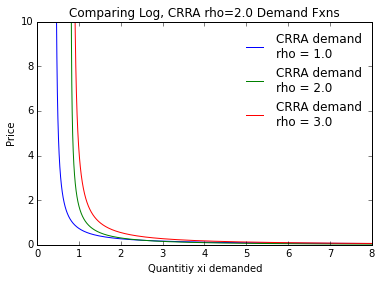

In [9]:
# Create a list of agents for each of the rho values used above:
agents = []
for crra in rho_list:
    agents.append( AssetPricingAgent(beta=beta, rho=crra, 
                                     D=D_vals, D_probs=D_probs, 
                                     y0=xi1*d1, xi0=xi1) )

# Now re-create the plots from above:
agent_demands = []
for agent in agents:
    agent_demands.append([])
    for p1 in prices:
        agent_demands[-1].append(agent.demand(p1))

    # Plot against prices:
    plt.plot(agent_demands[-1], prices, label="CRRA demand\nrho = "+str(agent.rho))
plt.xlabel("Quantitiy xi demanded")
plt.ylabel("Price")
plt.xlim([0.0, 8.0])
plt.legend(loc='best', frameon=False)
plt.title("Comparing Log, CRRA rho="+str(rho)+" Demand Fxns")
plt.show()



Now to find agent demands by clearing markets for excess demand:

In [17]:
class AssetMarket(object):

    def __init__(self, agents, D, D_probs, aggregate_asset_endowment=1.0, seed=None, lucas_tree=False):
        '''
        Market simply consists of collection of agents.

        lucas_tree: True means agents get same allocation of xi0 every morning
        '''

        self.seed=seed
        self.RNG = np.random.RandomState(self.seed)
        self.lucas_tree = lucas_tree
        self.agents = agents
        self.price_history = []
        self.volume_history = []
        self.payoff_history = []


        self.bilateral_price_history = []
        self.bilateral_volume_history = []
        self.bilateral_trade_partner_history = []


        self.total_agent_cash_wealth_history = []
        self.total_agent_initial_asset_endowment = []
        #self.total_agent_asset_volume = []

        self.aggregate_asset_endowment = aggregate_asset_endowment

        # Set up storage for agent values:
        self.agents_history = [] # Store agent variables here.
        for i in range(len(self.agents)):
            temp_storage = {'y':[],'c':[],'xi':[]}
            self.agents_history.append(temp_storage)

        # To find reasonable "first guess" price, find the risk-neutral asset
        # asset price for first-agent's preferences:
        agent0 = self.agents[0]
        self.p0_guess = agent0.beta * np.dot(agent0.D, agent0.D_probs)
        if self.p0_guess <= 0.0:
            self.p0_guess = 1e-5
        self.p_tm1 = self.p0_guess

        # Set up the dividend process:
        # Ensure that dividend payoffs are sorted from smallest to largest:
        self.D = np.array(D)
        self.D_probs = np.array(D_probs)
        ii = np.argsort(self.D)
        self.D = self.D[ii]
        self.D_probs = self.D_probs[ii]

        # Quick check:
        assert np.isclose(np.sum(D_probs), 1.0), "Problem: p_dividend does not sum to 1.0: np.sum(D_probs) = " + str(np.sum(D_probs))

        D_seed = self.RNG.randint(low=0, high=(2**31)-1)
        self.D_process = DiscreteRV(self.D_probs, self.D, seed=D_seed)
        # Done


    def run_markets(self, T):
        '''
        Run market for T periods.
        '''

        # Draw dividend:
        D = self.D_process.draw(T)

        for t in range(T):
            # Clear markets:
            pstar = self.clear_market()

            # Update
            self.price_history.append(pstar)
            self.payoff_history.append(D[t])

            # Get agent starting wealth, total agent initial asset endowment,
            # and total volume traded.
            # Important to do the following update before updating agent values:
            total_agent_initial_cash = 0.0
            total_agent_initial_asset_endowment = 0.0
            total_agent_asset_volume = 0.0
            for agent in self.agents:
                total_agent_initial_cash += agent.y  # Get wealth they started the period with
                total_agent_initial_asset_endowment += agent.xi0
                total_agent_asset_volume += np.abs(agent.xi0 - agent.demand(pstar))

            self.total_agent_cash_wealth_history.append(total_agent_initial_cash)
            self.total_agent_initial_asset_endowment.append(total_agent_initial_asset_endowment)
            self.volume_history.append(total_agent_asset_volume)

            # Now update agents and histories:
            self.update_agents(pstar=pstar, d=D[t])
        # Done


    def excess_demand(self, p, total_supply, agents):
        '''
        Iterate over all agents and ask for demand given price.
        '''

        '''
        if agents is None:
            agents = self.agents

        if total_supply is None:
            total_supply = self.aggregate_asset_endowment
        '''

        total_demand = 0.0
        for an_agent in agents:
            total_demand += an_agent.demand(p)

        return total_demand - total_supply


    def clear_market(self, these_agents=None, p0=None):
        '''
        Given an initial price guess, zero-find on total asset demand.

        p0 is initial price.
        '''

        if these_agents is None:
            these_agents = self.agents

        # Set intial price guess
        if p0 is None:
            p0 = self.p_tm1
            # Note: currently not using first guess....

        # Zero-find to determine price:
        supply_to_use = sum((agent.xi0 for agent in these_agents))

        p, root_results = brentq(f=self.excess_demand, args=(supply_to_use, these_agents), a=0.0001, b=1000, full_output=True, disp=True)

        if not root_results.converged:
            print "WARNING: root_results.converged not True!:  root_results.converged = ", root_results.converged
            print "root_results:", root_results

        return p

    def update_agents(self, pstar, d):
        '''
        Given pstar, update all agent histories.
        '''
        for i, agent in enumerate(self.agents):
            # Determine and save choices:
            xi = agent.demand(pstar)
            ct = agent.y + pstar*agent.xi0 - pstar*xi
            #print "new c=calc"
            self.agents_history[i]['c'].append(ct)
            self.agents_history[i]['y'].append(agent.y)
            self.agents_history[i]['xi'].append(xi)

            # Update agent value:
            agent.y = xi*d
            if not self.lucas_tree:
                agent.xi0 = xi
            agent.update_utility_demand()
        # Done


Now let's run some price clearning code:


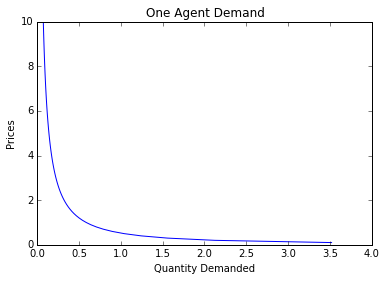

Making one agent pessimistic!


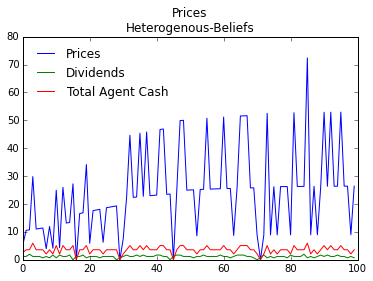

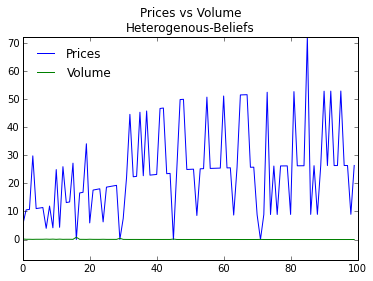

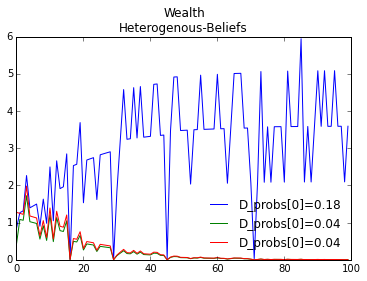

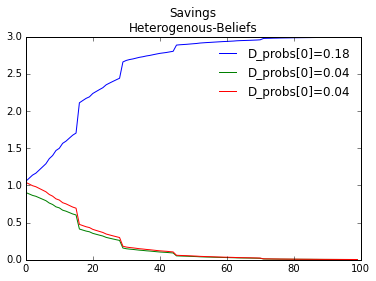

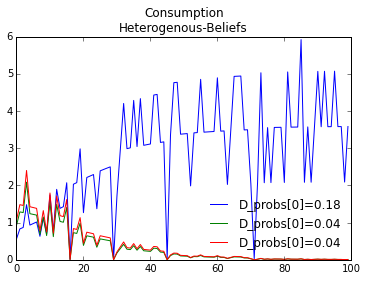

In [27]:
from copy import deepcopy
from discrete_rv import DiscreteRV
from scipy.optimize import brentq
import csv

y0=xi1*d1
seed = 98765

# Define an agent, and then find some prices:
an_agent = AssetPricingAgent(beta=beta,
                            rho=rho,
                            D=D_vals,
                            D_probs=D_probs,
                            y0=y0)

# Plot the demand function for various prices:
prices = np.linspace(0.1,10,100)
demands = []
for p in prices:
    demands.append(an_agent.demand(p))

plt.plot(demands,prices)
plt.xlabel("Quantity Demanded")
plt.ylabel("Prices")
plt.title("One Agent Demand")
plt.show()
plt.close()

# Let's try running the market:
agent1 = deepcopy(an_agent)  # Average but wrong expectations
agent2 = deepcopy(an_agent)  # Poor but all else equal
agent3 = deepcopy(an_agent)  # Rich but all else equal

total_two_agent_wealth = agent2.y + agent3.y
agent_2_fraction = (1.0/4.0)
agent2.y = agent_2_fraction * (total_two_agent_wealth)   # Cut to 1/3 of two agents summed wealth
#agent2.rho *=1.2
agent2.update_utility_demand()

agent3.y = (1.0-agent_2_fraction) * (total_two_agent_wealth)   # Set to 2/3 of two agents summed wealth
agent3.update_utility_demand()

# Give agent 1 wrong expectations:
INCLUDE_PESSIMIST = True
if INCLUDE_PESSIMIST:
    agent1.D_probs[0] *= 5.0    # Increase probability of lowest/higest state
    agent1.renormalize_beliefs()
    agent1.update_utility_demand()
    print "Making one agent pessimistic!"

    
total_supply = np.sum((agent.xi0 for agent in agents_to_use))

agents_to_use = [agent1, agent2, agent3]
supply_to_use = total_supply #total_supply*len(agents_to_use)

# Set each agent's initial asset holding endowment:
for one_agent in agents_to_use:
    one_agent.xi0 = 1.0 #supply_to_use/float(len(agents_to_use))
    one_agent.update_utility_demand()


# Define the market:
market = AssetMarket(agents=agents_to_use,
                     D=D_vals, D_probs=D_probs,
                     aggregate_asset_endowment=supply_to_use,
                     seed=seed)

# Define second market for bilateral trade experiment:
market2 = deepcopy(market)

# Run the market for T periods:
T=100
market.run_markets(T=T)


# Set a flag text:
extra_descrip = ""
if INCLUDE_PESSIMIST:
    extra_descrip = "Heterogenous-Beliefs"
else:
    extra_descrip = "Homogenous-Beliefs"

# Drop a csv file:
var_names = ['dividend_eop','price_mid','volume_mid','agent_cash_bop','total_asset_endowment_bop']

# repeat names as markers for dict:
var_to_write = {'dividend_eop':market.payoff_history,
            'price_mid':market.price_history,
            'volume_mid':market.volume_history,
            'agent_cash_bop':market.total_agent_cash_wealth_history,
            'total_asset_endowment_bop':market.total_agent_initial_asset_endowment}

assert (set(var_names) == set(var_to_write.keys())) and (len(var_names) == len(var_to_write.keys())), "List of names var_names not equal to keys in dict var_to_write!"

# Open csv file
with open('asset_sim_data-'+ extra_descrip +'.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow(var_names)
    # Now construct the "cross section" rows of the data:\
    first_key = var_names[0]
    all_rows = []
    for i in range(len(var_to_write[first_key])):
        temp_row = []
        for key in var_names:
            temp_row.append(var_to_write[key][i])
        all_rows.append(temp_row)
        temp_row = None ## "Disconnect"

    writer.writerows(all_rows)
# Now close.

# Plot Prices quickly:
plt.plot(market.price_history, label="Prices")
plt.plot(market.payoff_history, label="Dividends")
plt.plot(market.total_agent_cash_wealth_history, label="Total Agent Cash")
plt.legend(loc='best',frameon=False)
plt.title("Prices"+'\n'+extra_descrip)
plt.savefig("Prices-" + extra_descrip + ".pdf")
plt.show()

# Plot Prices vs volume quickly:
min_y = min(min(market.price_history), min(market.volume_history))
max_y = max(max(market.price_history), max(market.volume_history))
plt.plot(market.price_history, label="Prices")
plt.plot(market.volume_history, label="Volume")
plt.ylim(min_y - 0.1*(max_y-min_y), max_y)
plt.legend(loc='best',frameon=False)
plt.title("Prices vs Volume\n"+ extra_descrip)
plt.savefig("Prices-vs-Volume-" + extra_descrip + ".pdf")
plt.show()


# Plot incomes quickly:
for i in range(len(market.agents)):
    plt.plot(market.agents_history[i]['y'], label="D_probs[0]="+str(round(market.agents[i].D_probs[0],2)))
plt.legend(loc='best',frameon=False)
plt.title("Wealth\n" + extra_descrip)
plt.savefig("Wealth-" + extra_descrip + ".pdf")
plt.show()

# Plot xi quickly:
for i in range(len(market.agents)):
    plt.plot(market.agents_history[i]['xi'], label="D_probs[0]="+str(round(market.agents[i].D_probs[0],2)))
plt.legend(loc='best',frameon=False)
plt.title("Savings\n" + extra_descrip)
plt.savefig("Savings-" + extra_descrip + ".pdf")

plt.show()


# Plot ct quickly:
for i in range(len(market.agents)):
    plt.plot(market.agents_history[i]['c'], label="D_probs[0]="+str(round(market.agents[i].D_probs[0],2)))
plt.legend(loc='best',frameon=False)
plt.title("Consumption\n" + extra_descrip)
plt.savefig("Consumption-" + extra_descrip + ".pdf")
plt.show()


In [29]:
market.price_history


[5.215578472558116,
 10.562069984916059,
 10.734645034743313,
 29.82633695905726,
 11.027120578442494,
 11.213885725993237,
 11.405825623678364,
 3.9896682357069198,
 11.929378259885196,
 4.174537793937429,
 24.93479185730596,
 4.3482340876624495,
 25.971816119084124,
 13.167938327914197,
 13.397930437233933,
 27.226816946358888,
 0.0011360522444560934,
 16.59968012287521,
 16.83885883140177,
 34.13956306145559,
 5.918579635684974,
 17.62624059594852,
 17.856728493443928,
 18.084639355094346,
 6.277902560891049,
 18.66963091666827,
 18.88672375491154,
 19.10048689828751,
 19.310795796533622,
 0.001509298531006664,
 7.480763347323264,
 22.132292889764106,
 44.62738278120053,
 22.377758641885332,
 22.515181433075508,
 45.38062591334785,
 22.742706966383448,
 45.82793148236888,
 22.95923197469638,
 23.08017194015898,
 23.197560898150275,
 46.721505643090765,
 46.8832110395878,
 23.469491777645267,
 23.57516915377047,
 0.001719217961941336,
 24.820756785089028,
 49.90359775391604,
 49.9910

Next possible steps:

* examine learning about prices -- "how quickly does learning converge when agents are learning *only* from exogenous shocks?"
    * Examine OLS first, but multiple possible:
        * examine OLS learning process on prices
        * examine bayesian learning process on prices
        * examine kalman filter learning on prices
          - note: requires a model of "movement" from state to another
* examine basics when price process part of expectations as well. 
    * *this* is probably our actual concern. 
